In [223]:
import netCDF4 as nc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import os

In [224]:
# Load the NetCDF file
file_path = '/Users/zuhair/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/Research/current-projects/strain2D/Strain_2D/example/Output/gpsgridder/NC_files/MYM_ITRF_gpsgridder_strain.nc'
ds = nc.Dataset(file_path)

# Load the earthquakedata
earthquake_file_path = '../data/mainshocks_Reasenberg.csv'
earthquake_data = pd.read_csv(earthquake_file_path)

# Check the available variables
print(ds.variables.keys())

# Extract the maximum shear strain rate
max_shear_strain = ds['max_shear'][:]
latitudes = ds['y'][:]
longitudes = ds['x'][:]

# Define the region of interest
min_lat_roi, max_lat_roi = 15, 28
min_lon_roi, max_lon_roi = 90, 98

dict_keys(['Ve', 'Vn', 'exx', 'eyy', 'exy', 'azimuth', 'rotation', 'I2', 'dilatation', 'max_shear', 'x', 'y'])


### Define Grid Parameters:

In [226]:
grid_size = 0.1
lat_bins = np.arange(min_lat_roi, max_lat_roi + grid_size, grid_size)
lon_bins = np.arange(min_lon_roi, max_lon_roi + grid_size, grid_size)
lon_grid, lat_grid = np.meshgrid(lon_bins, lat_bins)

### Interpolate Strain Rates:

In [228]:
points = np.array([(lon, lat) for lat in latitudes for lon in longitudes])
values = max_shear_strain.flatten()
interpolated_strain_rates = griddata(points, values, (lon_grid, lat_grid), method='linear')

### Flatten and Sort Strain Rates:

In [230]:
flattened_strain_rates = interpolated_strain_rates.flatten()
sorted_indices = np.argsort(flattened_strain_rates)[::-1]
sorted_strain_rates = flattened_strain_rates[sorted_indices]
sorted_strain_rates = np.nan_to_num(sorted_strain_rates)

### Filter Earthquake Data:

In [232]:
filtered_earthquake_locations_roi = earthquake_data[
    (earthquake_data['latitude'] >= min_lat_roi) &
    (earthquake_data['latitude'] <= max_lat_roi) &
    (earthquake_data['longitude'] >= min_lon_roi) &
    (earthquake_data['longitude'] <= max_lon_roi) &
    (earthquake_data['date'] >= '1970-01-01') &
    (earthquake_data['date'] <= '2022-11-31') &
    (earthquake_data['magnitude'] > 3.8) &
    (earthquake_data['depth'] < 30)
]

### Create Earthquake Count Grid:

In [234]:
earthquake_count_grid = np.zeros((len(lat_bins) - 1, len(lon_bins) - 1))
x_indices = np.digitize(filtered_earthquake_locations_roi['longitude'], lon_bins) - 1
y_indices = np.digitize(filtered_earthquake_locations_roi['latitude'], lat_bins) - 1

for x_idx, y_idx in zip(x_indices, y_indices):
    if 0 <= x_idx < earthquake_count_grid.shape[1] and 0 <= y_idx < earthquake_count_grid.shape[0]:
        earthquake_count_grid[y_idx, x_idx] += 1

### Flatten and Sort Earthquake Counts:

In [236]:
flattened_earthquake_counts = earthquake_count_grid.flatten()
min_length = min(len(sorted_indices), len(flattened_strain_rates), len(flattened_earthquake_counts))
sorted_indices = sorted_indices[:min_length]
sorted_strain_rates = sorted_strain_rates[:min_length]
flattened_earthquake_counts = flattened_earthquake_counts[:min_length]
valid_sorted_indices = [idx for idx in sorted_indices if idx < len(flattened_earthquake_counts)]
sorted_earthquake_counts = flattened_earthquake_counts[valid_sorted_indices]
sorted_strain_rates = sorted_strain_rates[:len(valid_sorted_indices)]
sorted_strain_rates = np.nan_to_num(sorted_strain_rates)

### Calculate Cumulative Geodetic Potency Rate:

In [238]:
grid_cell_area = (111.32 * grid_size) * (111.32 * grid_size)
cumulative_potency_rate = np.cumsum(sorted_strain_rates * grid_cell_area)
normalized_cumulative_potency_rate = cumulative_potency_rate / cumulative_potency_rate[-1] if cumulative_potency_rate[-1] != 0 else np.zeros_like(cumulative_potency_rate)

### Calculate Cumulative Earthquake Counts:

In [240]:
cumulative_earthquake_counts = np.cumsum(sorted_earthquake_counts)
normalized_cumulative_earthquake_counts = cumulative_earthquake_counts / cumulative_earthquake_counts[-1] if cumulative_earthquake_counts[-1] != 0 else np.zeros_like(cumulative_earthquake_counts)

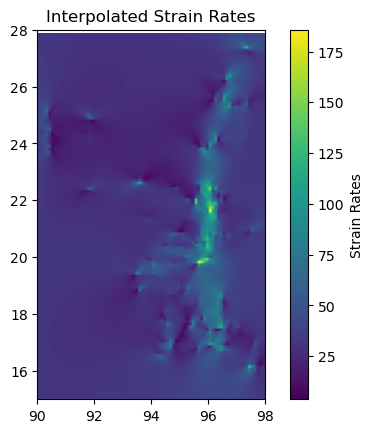

In [241]:
plt.figure()
plt.imshow(interpolated_strain_rates, extent=(min_lon_roi, max_lon_roi, min_lat_roi, max_lat_roi), origin='lower', cmap='viridis')
plt.colorbar(label='Strain Rates')
plt.title('Interpolated Strain Rates')
plt.show()

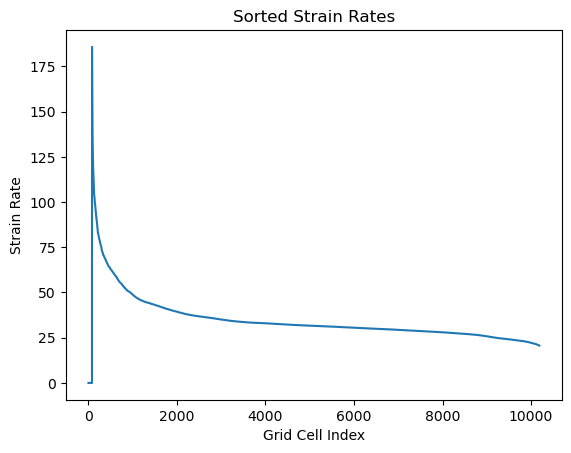

In [242]:
plt.figure()
plt.plot(sorted_strain_rates)
plt.title('Sorted Strain Rates')
plt.xlabel('Grid Cell Index')
plt.ylabel('Strain Rate')
plt.show()

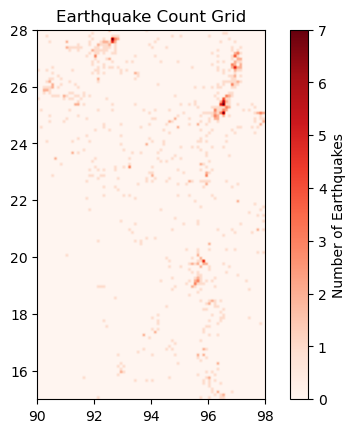

In [243]:
plt.figure()
plt.imshow(earthquake_count_grid, extent=(min_lon_roi, max_lon_roi, min_lat_roi, max_lat_roi), origin='lower', cmap='Reds')
plt.colorbar(label='Number of Earthquakes')
plt.title('Earthquake Count Grid')
plt.show()

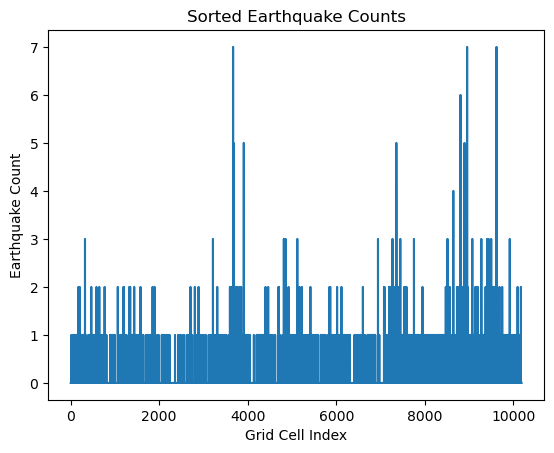

In [244]:
plt.figure()
plt.plot(sorted_earthquake_counts)
plt.title('Sorted Earthquake Counts')
plt.xlabel('Grid Cell Index')
plt.ylabel('Earthquake Count')
plt.show()

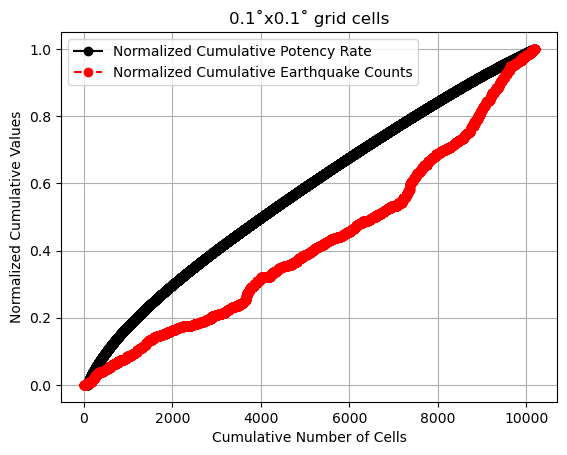

In [245]:
plt.figure()
plt.plot(range(1, len(normalized_cumulative_potency_rate) + 1), normalized_cumulative_potency_rate, label='Normalized Cumulative Potency Rate', marker='o', color='k')
plt.plot(range(1, len(normalized_cumulative_earthquake_counts) + 1), normalized_cumulative_earthquake_counts, label='Normalized Cumulative Earthquake Counts', linestyle='--', marker='o', color='r')
plt.xlabel('Cumulative Number of Cells')
plt.ylabel('Normalized Cumulative Values')
plt.title(f'{grid_size}˚x{grid_size}˚ grid cells')
plt.legend()
plt.grid(True)
plt.show()